#  Hands on with the TigerGraph Graph Data Science Library and Python
### CSCI 5980

Learn how to utilize TigerGraph's Graph Data Science Library to perform in-database machine learning and feature extraction through a hands-on example. We will use TigerGraph and Python with a provider referral network to help gain an understanding of how different algorithms help solve business problems.

## TigerGraph In-Database Graph Data Science Library
The TigerGraph In-Database Graph Data Science Library contains 50+ graph data science algorithms, all of which are open source and available on GitHub, found here: https://github.com/tigergraph/gsql-graph-algorithms. They take advantage of TigerGraph's Native Parallel Graph design and are written in GSQL. Documentation of the algorithms that are available can be found here: https://docs.tigergraph.com/graph-algorithm-library.

Running data science algorithms within the database removes the need for data transfer and keeps the richer graph information in your queries.

## Install Python Packages

## Connect to TigerGraph Instance
We are using pyTigerGraph to connect to the TigerGraph instance. We will first define our connection credentials and settings, then verify our connection.

In [1]:
from pyTigerGraph import TigerGraphConnection

conn=TigerGraphConnection(
    host="https://parker-umn.i.tgcloud.io",
    graphname="MyGraph",
    gsqlSecret="2j4a3138vjq7p2jeugltiv7bp8k189os"
)
conn.getToken("2j4a3138vjq7p2jeugltiv7bp8k189os")

('m31m0hjl332a99pbvt45o6c0snsd5nhh', 1665781516, '2022-10-14 21:05:16')

In [2]:
conn.echo()

'Hello GSQL'

In [3]:
print(conn.gsql("LS"))
#print(conn.getEndpoints(dynamic=True))

---- Global vertices, edges, and all graphs
Vertex Types:
- VERTEX Specialty(PRIMARY_ID id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX SubSpecialty(PRIMARY_ID id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX Prescriber(PRIMARY_ID Prescriber_id STRING, pageRank FLOAT, communityId INT) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX Claim(PRIMARY_ID Claim_id STRING, rx_fill_date DATETIME, ICD10Code STRING, ICD10CodeDescription STRING, CodeGroupTitle STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX Patient(PRIMARY_ID Patient_id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
Edge Types:
- DIRECTED EDGE submitted_by(FROM Claim, TO Prescriber) WITH REVERSE_EDGE="reverse_submitted_by"
- DIRECTED EDGE reverse_submitted_by(FROM Prescriber, TO Claim) WITH REVERSE_EDGE="submitted_by"
- DIRECTED EDGE associated(FROM Claim, TO 

## Create Referral Edges
The graph starter kit doesn't currently have referral edges loaded. Instead, a query uses claims data to infer referral edges, and creates the edge between two prescribers. We will install this query and then run it to create these edges.

In [ ]:
print(conn.gsql("USE GRAPH MyGraph\n INSTALL QUERY ex2_createReferralEdge"))
print(conn.gsql("USE GRAPH MyGraph\n INSTALL QUERY ex2_main_query"))

conn.runInstalledQuery("ex2_main_query")

Using graph 'MyGraph'
Start installing queries, about 1 minute ...
ex2_createReferralEdge query: curl -X GET 'https://127.0.0.1:9000/query/MyGraph/ex2_createReferralEdge?inputPrescriber=VALUE'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.
Select 'm1' as compile server, now connecting ...
Node 'm1' is prepared as compile server.

Query installation finished.
Using graph 'MyGraph'
Start installing queries, about 1 minute ...
ex2_main_query query: curl -X GET 'https://127.0.0.1:9000/query/MyGraph/ex2_main_query'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.
Select 'm1' as compile server, now connecting ...
Node 'm1' is prepared as compile server.

Query installation finished.


[{'all_prescribers': [{'v_id': 'pre18',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre50',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre86',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre15',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre97',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre9',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre10',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre37',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre42',
    'v_type': 'Prescriber',
    'attributes': {'pageRank': 0, 'communityId': 0}},
   {'v_id': 'pre52',
    'v_type': 'Prescriber',
    'a

## Louvain Modularity Community Detection

The Louvain Algorithm creates communities by maximizing a metric called **modularity**. The higher the modularity, the vertices within that community are more densely connected than that of a randomly-connected graph.

The documentation of Louvain Community Detection is found here: https://docs.tigergraph.com/graph-algorithm-library/community/louvain-method-with-parallelism-and-refinement.

In [9]:
louvain = '''
CREATE QUERY tg_louvain_parallel (SET<STRING> v_type, SET<STRING> e_type, STRING wt_attr,
  INT iter1=10, INT iter2=10, INT iter3=10, INT split=10, BOOL print_accum = TRUE,
  STRING result_attr = "", STRING file_path = "", BOOL comm_by_size = TRUE) {
 /*
 * Louvain Method with Parallelism and Refinement
 * https://arxiv.org/pdf/1304.4453
 * The minimum label heuristics are implemented: https://doi.org/10.1016/j.parco.2015.03.003
 
Parameters:
 * v_type: vertex types to traverse        print_accum: print JSON
 * e_type: edge types to traverse          result_attr: INT attr to store results to
                                           file_path: file to write CSV output to
 * wt_attr: attribute for edge weights. The wt_attr data type is hardcoded to INT. FLOAT
  or DOUBLE can be supported by changing "INT" to "FLOAT"/"DOUBLE" (~10 instances) below. 
 * iter: There are three phases in the algorithm -- move, merge and refine. Their max number of iterations are set by iter1, iter2, iter3 respectively.
 * split: To save memory, split number is 10 by default. When the split number is larger, the query is closer to sequential Louvain Method, which is slower. When the split number is 1, the query is parallel, but requires more memory. 
 * comm_by_size: list community ids by size
*/
    
    TYPEDEF TUPLE <INT csize, INT number> ClusterNum;
    TYPEDEF TUPLE <VERTEX node, INT cid, FLOAT deltaQ> vDeltaQ;
    HeapAccum<vDeltaQ>(1, deltaQ DESC, cid ASC) @largestDeltaQ;   # if deltaQ is the same, select the one with mininal vid 
    MapAccum<INT, FLOAT> @@totIncidentCluster;   # sum of weight incident to clusters
    MapAccum<INT, INT> @@clusterSizes;           # size of a cluster
    MapAccum<INT, FLOAT> @weightToCluster; # weight from a vertex incident to that cluster
    SumAccum<FLOAT> @@totalWeight;   # total weight of all edges
    SumAccum<FLOAT> @weight;         # total weight incident to this vertex
    SumAccum<FLOAT> @cweight;        # total weight incident to this aggregate vertex
    SumAccum<INT> @uid;              # which vertex it belongs to
    SumAccum<INT> @cid;              # which cluster it belongs to
    SumAccum<INT> @vid;              # internal id
    SumAccum<FLOAT> @deltaQ;         # contribution to the modularity
    SumAccum<FLOAT> @@modularity;
    SumAccum<FLOAT> @@modularity2;
    MapAccum<INT, MapAccum<INT, FLOAT>> @@weightToClusterMap;   # calculate edges between communities 
    MapAccum<INT, SetAccum<INT>> @@moveComm; # map of communities that changed community id
    MapAccum<INT, MinAccum<VERTEX>> @@representMap;
    SetAccum<VERTEX> @@representSet;
    MapAccum<INT, FLOAT> @@vertexMap;
    MapAccum<INT, MapAccum<INT, FLOAT>> @@edgeMap;
    HeapAccum<ClusterNum>(100, csize ASC) @@clusterDist;
    MapAccum<INT, INT> @@clusterMap;
    MapAccum<INT, ListAccum<INT>> @@clusterMembers;
    FLOAT last_modularity = 0;
    FLOAT last_modularity2 = 0;
    INT iteration;
    INT Iter1; 
    FLOAT epsilon = 0.0001;
    INT iteration2;
    INT partitions;
    INT loop;
    INT debug = 0;  # debug: 0, no modularity info; 1, show debug log; 2, modularity for each iteration
    FILE f (file_path);
    
    partitions = split;
    CASE WHEN split < 1 THEN
            partitions = 1;
    END;
        
# Initialize: count edges and set a unique cluster ID for each vertex
    Start = {v_type};
    S = SELECT s 
        FROM Start:s -(e_type:e)-> :t
        ACCUM @@totalWeight += e.getAttr(wt_attr,"INT")*1.0,
            s.@weight += e.getAttr(wt_attr,"INT")*1.0
        POST-ACCUM s.@vid = getvid(s),
                   s.@uid = s.@vid,
                   s.@cid = s.@vid;  # Label each vertex with its own internal ID

# Special first iteration of Phase 1
    iteration = 1;
    S = SELECT s 
        FROM Start:s -(e_type:e)-> :t
        WHERE s.@cid > t.@cid
        ACCUM s.@largestDeltaQ += vDeltaQ(t, t.@cid, e.getAttr(wt_attr,"INT")*1.0 - 2 * s.@weight * s.@weight/ @@totalWeight) 
              # weightToCluster is just e.getAttr(wt_attr,"INT")*1.0
        POST-ACCUM INT bestCluster = s.@largestDeltaQ.top().cid,
                   IF s.@largestDeltaQ.size() > 0 and s.@largestDeltaQ.top().deltaQ > 0 and s.@cid != bestCluster THEN 
                           s.@cid = bestCluster
                   END,
                   s.@largestDeltaQ.clear();

    S = SELECT s
        FROM Start:s-(e_type:e)-:t
        WHERE s.@cid == t.@cid
        ACCUM @@modularity += e.getAttr(wt_attr,"INT")*1.0 - s.@weight * t.@weight / (@@totalWeight);

    @@modularity = @@modularity / @@totalWeight;                      
    PRINT iteration AS Phase1Iter, @@modularity;
    log(debug > 0, "[redrain]#move", iteration, @@modularity);
        
# Phase 1 -- Move
# For each vertex, calculate the change in modularity FROM adding it to each of the nearby clusters
# Add vertex to cluster with highest positive change in modularity
# Repeat the above until no vertices change cluster anymore
    S = SELECT s 
        FROM Start:s
        ACCUM @@totIncidentCluster += (s.@cid -> s.@weight); 
      
    iteration = 1;
    Iter1 = iter1 - 1;
      
    WHILE (iteration < 2 OR @@modularity - last_modularity > epsilon) LIMIT Iter1 DO
        iteration = iteration + 1;
        loop = 0;
        WHILE (loop < partitions) DO 
            S = SELECT s 
                FROM Start:s -(e_type:e)-> :t
                WHERE s.@uid % partitions == loop    # for different split
                    # At least one cluster not singlet(a cluster on its own). If both clusters are singlets, consider only when the label of target is smaller to avoid swap
                    AND (( abs(s.@weight - @@totIncidentCluster.get(s.@cid)) > epsilon   # s is not a singlet 
                    OR abs(t.@weight - @@totIncidentCluster.get(t.@cid)) > epsilon )     # or t is not a singlet
                    OR (abs(s.@weight - @@totIncidentCluster.get(s.@cid)) < epsilon      # s is a singlet 
                    AND abs(t.@weight - @@totIncidentCluster.get(t.@cid)) < epsilon      # t is also a singlet
                    AND s.@cid > t.@cid) )                                               # consider only when target label is smaller
                ACCUM s.@weightToCluster += (t.@cid -> e.getAttr(wt_attr,"INT")*1.0)
                POST-ACCUM INT bestCluster = s.@cid,
                    FLOAT maxDeltaQ = 0.0,
                    FLOAT deltaQ_new = 0.0,
                    FOREACH (cluster, weightToC) IN s.@weightToCluster DO   #would be better if this can be distributed
                        FLOAT incident = @@totIncidentCluster.get(cluster),
                        deltaQ_new = weightToC - 2 * incident * s.@weight/ @@totalWeight,
                        IF deltaQ_new > maxDeltaQ OR (abs(deltaQ_new - maxDeltaQ) < epsilon AND cluster < bestCluster) THEN   # when deltaQ_new is equal to maxDeltaQ, and the cluster label is smaller, also change 
                               maxDeltaQ = deltaQ_new,
                               bestCluster = cluster
                        END
                    END,
                    IF s.@cid != bestCluster THEN 
                        @@totIncidentCluster += (s.@cid -> (-1 * s.@weight)),
                        @@totIncidentCluster += (bestCluster -> s.@weight),
                        s.@cid = bestCluster
                    END,
                    s.@weightToCluster.clear();
            loop = loop + 1;
        END;
        last_modularity = @@modularity;
        @@modularity = 0;
        T1 = SELECT s
            FROM Start:s-(e_type:e)-:t
            WHERE s.@cid == t.@cid
            ACCUM @@modularity += e.getAttr(wt_attr,"INT")*1.0 - s.@weight * t.@weight / (@@totalWeight);
        @@modularity = @@modularity / @@totalWeight;                      
        PRINT iteration AS Phase1Iter, @@modularity;
        log(debug > 0, "[redrain]#move", iteration, @@modularity);
    END;

# Phase 2 --  Merge     
    iteration2 = 0;
    WHILE (iteration2 < 2 OR @@modularity2 - last_modularity2 > epsilon) LIMIT iter2 DO
        iteration2 = iteration2 + 1;
        Start = SELECT s
                FROM Start:s
                ACCUM s.@uid = s.@cid;      
        # Select the vertices with minimal internal id to represent the coarsened graph
        Start = SELECT s
                FROM Start:s 
                ACCUM @@representMap += (s.@cid -> s);

        FOREACH (key, value) IN @@representMap DO
                @@representSet += value;                       
        END;      
        represent = {@@representSet};
        @@representMap.clear();
        @@representSet.clear();
        log(debug > 0, "[redrain]#2_merge", represent.size()); #@@clusterSizes.size());

    # Get @cweight from totalIncident
        represent = SELECT s
                    FROM represent:s
                    ACCUM s.@cweight = @@totIncidentCluster.get(s.@uid),
                          @@clusterSizes += (s.@cid -> 1);

        log(debug > 1, "[redrain]#2_merge", @@weightToClusterMap.size());
        iteration = 0;
        last_modularity = 0;
        @@modularity = 0;

        WHILE (iteration < 2 OR @@modularity - last_modularity > epsilon) limit iter1 DO
            iteration = iteration + 1;

            # Calculate.getAttr(wt_attr,"INT")*1.0 incident from vertex to cluster in coarsened graph; change every interation
            S = SELECT s
                FROM Start:s -(e_type:e)-:t
                WHERE s.@cid != t.@cid AND @@totIncidentCluster.get(s.@uid) > 0 AND @@totIncidentCluster.get(t.@cid) > 0   #@@totIncidentCluster keeps changing, can be 0
                ACCUM @@weightToClusterMap += (s.@uid -> (t.@cid -> e.getAttr(wt_attr,"INT")*1.0));  # from s, incident to some clusters. Not consider the same cluster
            represent = SELECT s 
                FROM represent:s
                POST-ACCUM INT bestCluster = s.@cid,
                    FLOAT maxDeltaQ = 0.0,
                    FLOAT deltaQ_new = 0.0,
                    FOREACH (cluster, weightToC) IN @@weightToClusterMap.get(s.@uid) DO 
                        FLOAT incident = @@totIncidentCluster.get(cluster),
                        IF @@clusterSizes.get(s.@cid) == 1 AND @@clusterSizes.get(cluster) == 1 AND s.@cid < cluster THEN
                               CONTINUE
                        END,
                        deltaQ_new = weightToC - 2 * incident * s.@cweight/ @@totalWeight, #total weight should be the same
                        IF deltaQ_new > maxDeltaQ OR abs(deltaQ_new - maxDeltaQ) < epsilon AND cluster < bestCluster THEN      # new cluster is smaller then the current best cluster
                               maxDeltaQ = deltaQ_new,
                               bestCluster = cluster
                        END
                    END,
                    IF s.@cid != bestCluster THEN
                        @@totIncidentCluster += (s.@cid -> (-1 * s.@cweight)),
                        @@totIncidentCluster += (bestCluster -> s.@cweight),
                        @@moveComm += (s.@uid -> bestCluster),
                        @@clusterSizes += (s.@cid -> -1),
                        @@clusterSizes += (bestCluster -> 1),
                        s.@cid = bestCluster
                    END;
            log(debug > 1, "[redrain]#2_merge", @@weightToClusterMap.size()); 
            @@weightToClusterMap.clear();

            log(debug > 1, "[redrain]#2_move:", @@moveComm.size());
            # move nodes
            S = SELECT s
                FROM Start:s
                WHERE @@moveComm.containsKey(s.@uid)
                POST-ACCUM FOREACH v IN @@moveComm.get(s.@uid) DO
                                   s.@cid = v
                           END;
            @@moveComm.clear();

            last_modularity = @@modularity;           
            @@modularity = 0;

            S = SELECT s
                FROM Start:s-(e_type:e)-:t
                WHERE s.@cid == t.@cid
                ACCUM @@modularity += e.getAttr(wt_attr,"INT")*1.0 - s.@weight * t.@weight / (@@totalWeight);
                @@modularity = @@modularity / @@totalWeight;
                PRINT iteration AS Phase1Iter, @@modularity;
            log(debug > 0, "[redrain]#2_move", iteration, @@modularity);
        END;

        S = SELECT s
            FROM represent:s
            ACCUM s.@cweight = 0;
        @@clusterSizes.clear();

        last_modularity2 = @@modularity2;
        @@modularity2 = @@modularity;
        PRINT iteration2 AS Phase2Iter, @@modularity2;
        log(debug > 0, "[redrain]#2_merge", iteration2, @@modularity2);					  
    END;
        
        
# Phase 3 -- Refinement
    iteration = 0;
    @@modularity = 0;
    WHILE (iteration < 2 OR @@modularity - last_modularity > epsilon) LIMIT iter3 DO
        iteration = iteration + 1;
        S = SELECT s 
            FROM Start:s -(e_type:e)-> :t
            WHERE abs(s.@weight - @@totIncidentCluster.get(s.@cid)) > epsilon OR abs(t.@weight - @@totIncidentCluster.get(t.@cid)) > epsilon OR (abs(s.@weight - @@totIncidentCluster.get(s.@cid)) < epsilon AND abs(t.@weight - @@totIncidentCluster.get(t.@cid)) < epsilon AND s.@cid > t.@cid)   # at least one cluster not only itself, or use smaller label
            ACCUM s.@weightToCluster += (t.@cid -> e.getAttr(wt_attr,"INT")*1.0)
            POST-ACCUM
                INT bestCluster = s.@cid,
                FLOAT maxDeltaQ = 0.0,
                FLOAT deltaQ_new = 0.0,
                FOREACH (cluster, weightToC) IN s.@weightToCluster DO   #would be better if this can be distributed
                    FLOAT incident = @@totIncidentCluster.get(cluster),
                    deltaQ_new = weightToC - 2 * incident * s.@weight/ @@totalWeight,
                    IF deltaQ_new > maxDeltaQ OR (abs(deltaQ_new - maxDeltaQ) < epsilon AND cluster < bestCluster) THEN   # when deltaQ_new is equal to maxDeltaQ, and the cluster label is smaller, also change 
                    maxDeltaQ = deltaQ_new,
                    bestCluster = cluster
                    END
                END,
                IF s.@cid != bestCluster THEN 
                    @@totIncidentCluster += (s.@cid -> (-1 * s.@weight)),
                    @@totIncidentCluster += (bestCluster -> s.@weight),
                    s.@cid = bestCluster
                END,
                s.@weightToCluster.clear();

        last_modularity = @@modularity;
        @@modularity = 0;
        T1 = SELECT s
             FROM Start:s-(e_type:e)-:t
             WHERE s.@cid == t.@cid
             ACCUM @@modularity += e.getAttr(wt_attr,"INT")*1.0 - s.@weight * t.@weight / (@@totalWeight);
        @@modularity = @@modularity / @@totalWeight;                      
        PRINT iteration AS Phase3Iter, @@modularity;
        log(debug > 0, "[redrain]#refine", iteration, @@modularity);
    END;
	
	Start = SELECT s FROM Start:s
	    POST-ACCUM
	        IF result_attr != "" THEN s.setAttr(result_attr, s.@cid) END,
	        IF file_path != "" THEN f.println(s, s.@cid) END
	    ;
	IF print_accum THEN
	    PRINT Start[Start.@cid];
	END;
    
    Start = {v_type};
    Start = SELECT s FROM Start:s
        POST-ACCUM @@clusterSizes += (s.@cid -> 1)
        ;
    log(TRUE, @@clusterSizes.size());

    IF comm_by_size THEN
        FOREACH (cluster, csize) IN @@clusterSizes DO
                @@clusterMembers += (csize -> cluster);
        END;
        PRINT @@clusterMembers;
    END;
}'''

# Uncomment the line below if there is already a tg_louvain_parallel query installed
# print(conn.gsql("USE GRAPH MyGraph\nDROP QUERY tg_louvain_parallel\n"))
print(conn.gsql("USE GRAPH MyGraph\n"+louvain+"\n INSTALL QUERY tg_louvain_parallel"))

Using graph 'MyGraph'
Successfully created queries: [tg_louvain_parallel].
Start installing queries, about 1 minute ...
tg_louvain_parallel query: curl -X GET 'https://127.0.0.1:9000/query/MyGraph/tg_louvain_parallel?v_type=VALUE&e_type=VALUE&wt_attr=VALUE&[iter1=VALUE]&[iter2=VALUE]&[iter3=VALUE]&[split=VALUE]&[print_accum=VALUE]&[result_attr=VALUE]&[file_path=VALUE]&[comm_by_size=VALUE]'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.
Select 'm1' as compile server, now connecting ...
Node 'm1' is prepared as compile server.

Query installation finished.


In [10]:
params = {
  "v_type": "Prescriber", 
  "e_type": "referral",
  "wt_attr": "num_patient",
  "iter1": 10, 
  "iter2": 10,
  "iter3": 10, 
  "split": 10,
  "print_accum": True,
  "result_attr": "communityId", 
  "file_path": "",
  "comm_by_size": True    
}

res = conn.runInstalledQuery("tg_louvain_parallel", params=params)

In [11]:
res[-1]["@@clusterMembers"]

{'11': [73400324],
 '6': [68157441, 75497473],
 '15': [0, 72351746, 68157440],
 '13': [71303169],
 '23': [77594629]}

In [12]:
def getProvidersInCommunity(res, cid):
  providers = res[-2]["Start"]
  result = []
  for provider in providers:
    if provider["attributes"]["Start.@cid"] == cid:
      result.append(provider["v_id"])
  return result

In [15]:
getProvidersInCommunity(res, 73400324)

['pre24',
 'pre81',
 'pre66',
 'pre48',
 'pre95',
 'pre39',
 'pre11',
 'pre36',
 'pre56',
 'pre30',
 'pre43']

In [14]:
getProvidersInCommunity(res, 72351746)

['pre65',
 'pre10',
 'pre64',
 'pre14',
 'pre42',
 'pre58',
 'pre16',
 'pre0',
 'pre23',
 'pre79',
 'pre94',
 'pre49',
 'pre61',
 'pre33',
 'pre19']

## PageRank
PageRank is the algorithm that originally ran Google's search engine, where it ranked the most influential webpages higher than less influential ones. A page was determined to be influential through its PageRank score, which is based off the importance of the pages that linked to it. Generalizing this, PageRank finds the most influential vertices in a graph based upon how influential the vertices that have edges to the desired vertex are.

The documentation of the PageRank query is found here: https://docs.tigergraph.com/graph-algorithm-library/centrality/pagerank.

In [16]:
feat = conn.gds.featurizer()

In [17]:
feat.installAlgorithm("tg_pagerank")

Installing and optimizing the queries, it might take a minute


'tg_pagerank'

In [21]:
params = {
  "v_type": "Prescriber",
  "e_type": "referral",
  "max_change": 0.001,
  "max_iter": 25,
  "damping": 0.85,
  "top_k": 150,
  "print_accum": True,
  "result_attr": "pageRank",
  "file_path": "",
  "display_edges": False
}

pr_res = feat.runAlgorithm("tg_pagerank", params=params)[0]["@@top_scores_heap"]

In [22]:
def getMostInfluentialInCommunity(community, pr_res):
  currentMaxScore = -1*float("inf")
  currentMaxId = ""
  for r in pr_res:
    if r["Vertex_ID"] in community:
      if r["score"] > currentMaxScore:
        currentMaxId = r["Vertex_ID"]
        currentMaxScore = r["score"]
  return (currentMaxId, currentMaxScore)

In [23]:
getMostInfluentialInCommunity(getProvidersInCommunity(res, 72351746), pr_res)

('pre23', 2.34658)

In [25]:
getMostInfluentialInCommunity(getProvidersInCommunity(res, 73400324), pr_res)

('pre66', 1.26382)

## Article Rank
Article Rank is very similar to PageRank, but it lowers the importance of low-degree vertices. We will compare the difference between PageRank and Article Rank in the Analysis section.

The documentation of the Article Rank query is found here: https://docs.tigergraph.com/graph-algorithm-library/centrality/article-rank.

In [28]:
feat.installAlgorithm("tg_article_rank")

Installing and optimizing the queries, it might take a minute


'tg_article_rank'

In [39]:
params = {
    "v_type": "Prescriber",
    "e_type": "referral",
    "top_k": 1000,
    "result_attr": "articleRank"
}

ar_res = feat.runAlgorithm("tg_article_rank", params=params, feat_name="articleRank", schema_name=["Prescriber"], global_schema=True)[0]["@@top_scores_heap"]

Global schema change succeeded.


In [40]:
ar_res[:5]

[{'Vertex_ID': 'pre23', 'score': 205912.26563},
 {'Vertex_ID': 'pre29', 'score': 185670.92188},
 {'Vertex_ID': 'pre69', 'score': 174932.4375},
 {'Vertex_ID': 'pre74', 'score': 162740.9375},
 {'Vertex_ID': 'pre60', 'score': 141031.67188}]

## Analysis

### Get Subspecialty Information

In [42]:
getPrescriberFeats = '''
CREATE QUERY getPrescriberFeats () {
  TYPEDEF TUPLE <subspecialty VERTEX<SubSpecialty>, community INT, pagerank FLOAT, articlerank FLOAT> feats;
  MapAccum<VERTEX<Prescriber>, feats> @@prescriberFeats;
  Start = {SubSpecialty.*};
  res = SELECT s 
        FROM Start:s -(subspecialty_prescriber)-> Prescriber:p
        ACCUM @@prescriberFeats += (p -> feats(s, p.communityId, p.pageRank, p.articleRank));
  PRINT @@prescriberFeats;
}
'''

# Uncomment the line below if there is already a getPrescriberFeats query installed
# print(conn.gsql("USE GRAPH MyGraph\nDROP QUERY getPrescriberFeats\n"))
print(conn.gsql("USE GRAPH MyGraph\n"+ getPrescriberFeats + "\n INSTALL QUERY getPrescriberFeats"))

Using graph 'MyGraph'
Successfully created queries: [getPrescriberFeats].
Start installing queries, about 1 minute ...
getPrescriberFeats query: curl -X GET 'https://127.0.0.1:9000/query/MyGraph/getPrescriberFeats'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.
Select 'm1' as compile server, now connecting ...
Node 'm1' is prepared as compile server.

Query installation finished.


In [43]:
import pandas as pd

providerFeats = pd.DataFrame(conn.runInstalledQuery("getPrescriberFeats")[0]["@@prescriberFeats"]).T

In [44]:
providerFeats = providerFeats.reset_index().rename({"index": "provider"}, axis="columns")
providerFeats["pagerank"] = providerFeats["pagerank"].astype("float")
providerFeats["articlerank"] = providerFeats["articlerank"].astype("float")

In [45]:
providerFeats

,provider,subspecialty,community,pagerank,articlerank
0,pre11,Shoulder Surgery,73400324,0.92374,63002.14063
1,pre61,Hand Surgery,72351746,2.04001,140422.67188
2,pre28,Orthopedic Surgery,71303169,0.71966,54603.78906
3,pre69,Shoulder Surgery,0,2.56451,174932.43750
4,pre62,Gynecology,71303169,1.44822,122392.43750
...,...,...,...,...,...
99,pre8,Cardiac Diagnostic,77594629,0.81836,68093.84375
100,pre21,Hand Surgery,68157441,0.59617,41530.15625
101,pre46,Shoulder Surgery,77594629,0.84570,60741.50391
102,pre26,Cardiac Diagnostic,68157441,0.27119,12418.96582


### Comparing PageRank and Article Rank
Let's take a look at the influence that different subspecialties have within the data, and compare the differences in ranking that PageRank and Article Rank produced. We will also look at the frequency of each subspecialty in the graph and how it correlates to the PageRank and ArticleRank scores.

#### Plotting Values by Subspecialty

In [46]:
subPRMean = providerFeats.groupby('subspecialty', as_index=False)['pagerank'].mean()
subARMean = providerFeats.groupby('subspecialty', as_index=False)['articlerank'].mean()

<AxesSubplot:ylabel='subspecialty'>

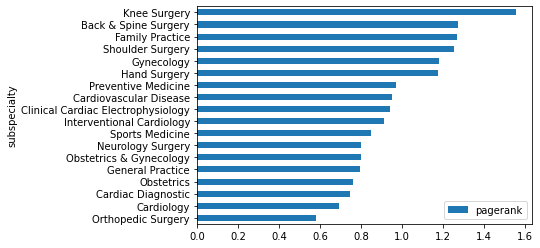

In [47]:
subPRMean.sort_values(by="pagerank").plot(x="subspecialty", y="pagerank", kind="barh")

<AxesSubplot:ylabel='subspecialty'>

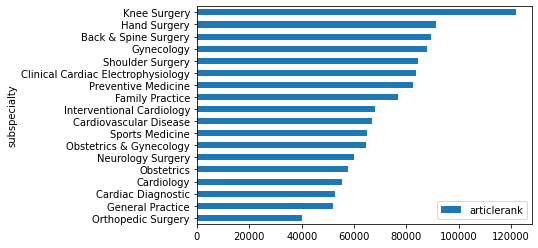

In [48]:
subARMean.sort_values(by="articlerank").plot(x="subspecialty", y="articlerank", kind="barh")

<AxesSubplot:>

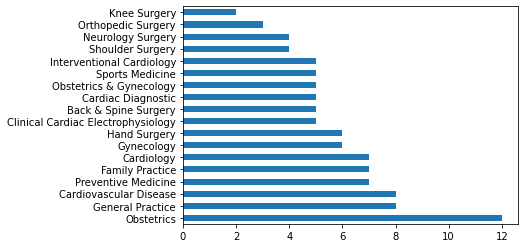

In [49]:
providerFeats["subspecialty"].value_counts().plot(kind="barh")

#### Correlation between Frequency, PageRank, and Article Rank

In [50]:
subFreq = pd.DataFrame(providerFeats["subspecialty"].value_counts()).reset_index().rename(columns={"index":"subspecialty", "subspecialty":"frequency"})
freqPR = subFreq.merge(subPRMean, on="subspecialty")
freqPRAR = freqPR.merge(subARMean, on="subspecialty")
freqPRAR

,subspecialty,frequency,pagerank,articlerank
0,Obstetrics,12,0.762273,57757.530111
1,General Practice,8,0.796602,51976.646314
2,Cardiovascular Disease,8,0.952115,66907.529981
3,Preventive Medicine,7,0.971496,82537.500559
4,Family Practice,7,1.269397,76608.576906
5,Cardiology,7,0.691751,55243.556640
6,Gynecology,6,1.180877,88035.281250
7,Hand Surgery,6,1.174620,91165.856120
8,Clinical Cardiac Electrophysiology,5,0.939042,83533.152346
9,Back & Spine Surgery,5,1.274378,89559.774220


In [51]:
freqPRAR.corr()

,frequency,pagerank,articlerank
frequency,1.000000,-0.276738,-0.314018
pagerank,-0.276738,1.000000,0.928759
articlerank,-0.314018,0.928759,1.000000


We see that PageRank and Article Rank are highly correlated to one another, which makes sense due to their similarity in computing influence. What is interesting is the lack of correlation to how often a subspecialty occurs compared to the average influence of the subspecialty computed by PageRank or Article Rank. This seems to suggest that in this dataset, prescribers do not get more referrals soley because they are in a more unique subspecialty.

### Comparing Community Influence
Let's take a look at the average influence scores within each community.

In [52]:
comPRMean = providerFeats.groupby('community', as_index=False)['pagerank'].mean()

<AxesSubplot:ylabel='community'>

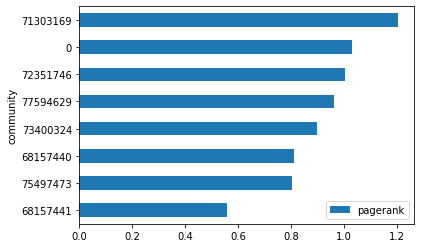

In [53]:
comPRMean.sort_values(by="pagerank").plot(x="community", y="pagerank", kind="barh")

In [54]:
comARMean = providerFeats.groupby('community', as_index=False)['articlerank'].mean()

<AxesSubplot:ylabel='community'>

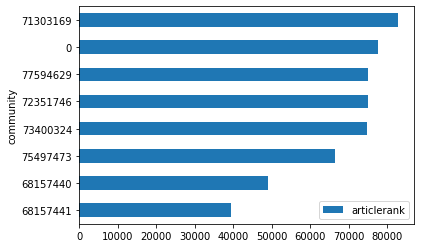

In [55]:
comARMean.sort_values(by="articlerank").plot(x="community", y="articlerank", kind="barh")

### Subspecialty Occurence within Communities
Let's take a look at the distribution of subspecialties within communities.

In [56]:
comSubSpecialty = providerFeats.groupby(["community"], as_index=False)

In [57]:
for key, item in comSubSpecialty:
    print("Community:", key)
    print(comSubSpecialty.get_group(key)["subspecialty"].value_counts(), "\n\n")

Community: 0
Family Practice           2
Sports Medicine           2
Obstetrics                2
Shoulder Surgery          1
Preventive Medicine       1
Back & Spine Surgery      1
General Practice          1
Cardiovascular Disease    1
Knee Surgery              1
Orthopedic Surgery        1
Cardiology                1
Gynecology                1
Name: subspecialty, dtype: int64 


Community: 68157440
Interventional Cardiology             2
Cardiovascular Disease                2
Obstetrics                            2
Cardiac Diagnostic                    1
Clinical Cardiac Electrophysiology    1
General Practice                      1
Family Practice                       1
Knee Surgery                          1
Preventive Medicine                   1
Orthopedic Surgery                    1
Neurology Surgery                     1
Hand Surgery                          1
Name: subspecialty, dtype: int64 


Community: 68157441
General Practice          1
Cardiology                1
Car

It looks as though subspecialties are relatively evenly distributed throughout each community, with Family Practice or General Practice physicians present in just about every community. This makes sense within our dataset, as usually these physicians are the ones that refer patients to a more specific physician.

## Conclusion
This notebook ran through various different algorithms found in the TigerGraph In-Database Graph Data Science Library, found here: https://github.com/tigergraph/gsql-graph-algorithms. Please reach out with any questions, either on the community site at https://community.tigergraph.com/, or the Discord server here: https://discord.gg/vFbmPyvJJN.